In [1]:
# Import Qiskit and IonQ
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_provider import IBMProvider
# from qiskit_ionq import IonQProvider

# Save the IBM account if needed
# token = 'token'
# QiskitRuntimeService.save_account(channel="ibm_quantum", token=token, overwrite=True)

# Load IBM and IonQ accounts
service = QiskitRuntimeService(channel="ibm_quantum", instance=None)
provider = IBMProvider()
# ionq_provider = IonQProvider()

# Display available backends
print(provider.backends())

[<IBMBackend('ibmq_qasm_simulator')>, <IBMBackend('ibmq_belem')>, <IBMBackend('simulator_mps')>, <IBMBackend('simulator_statevector')>, <IBMBackend('ibmq_manila')>, <IBMBackend('ibm_nairobi')>, <IBMBackend('ibmq_lima')>, <IBMBackend('ibm_oslo')>, <IBMBackend('ibmq_jakarta')>, <IBMBackend('ibmq_quito')>, <IBMBackend('simulator_stabilizer')>, <IBMBackend('ibm_lagos')>, <IBMBackend('ibm_perth')>, <IBMBackend('simulator_extended_stabilizer')>]


In [2]:
# Set backend like this
backend = "ibmq_qasm_simulator"

In [3]:
# Import packages
import numpy as np
import matplotlib.pyplot as plt
from qiskit_ibm_runtime import Session, Sampler, Options
from qw.staggered_dsg_circuit_3t_bin import *

In [4]:
# Overall setting
shots = 4000
size_degree = 2
displacement_dict = {"0000":0, "0001":1, "0010":1, 
                     "0011":9, "0100":7, "0101":4,
                     "0110":9, "0111":4, "1000":7}

In [5]:
# Simulation setting
steps = 300
dt = 0.01
layers = 10
t = np.linspace(dt, steps*dt, steps)
name = f'dsg_3tqw_bin_o{size_degree:d}_{steps*dt:.1f}s_{layers:d}ly'

In [6]:
# Build a circuit list.
circuits = []
for i in range(steps):
    circuits.append(staggered_dsg_circuit_3t_bin(size_degree, t[i], layers, model='XY'))
# circs[20].draw('mpl')

# Run QASM simulator
backend = "ibmq_qasm_simulator"
options = Options(simulator={"seed_simulator": 42}, resilience_level=0)
with Session(service=service, backend=backend):
    sampler = Sampler(options=options)
    job = sampler.run(
        circuits=circuits,
        shots=shots
    )
    results = job.result()

# Print job status
print(f">>> Job ID: {job.job_id()}")
print(f">>> Job Status: {job.status()}")

>>> Job ID: cgkd3m1rv8r4b3niuchg
>>> Job Status: JobStatus.DONE


In [7]:
# Extract (quasi-)probability distribution
qd_list = list()
for i in range(steps):
    qd_list.append(results.quasi_dists[i].binary_probabilities())

# Compute mean square displacement
# Count valid results only
msd_list = list()
for i in range(steps):
    valid_prob = 0
    for bit, prob in qd_list[i].items():
        valid_prob += (displacement_dict.get(bit, -1) > -1)*prob
    msd_temp = 0.
    for bit, prob in qd_list[i].items():
        msd_temp += displacement_dict.get(bit, 0)*prob/valid_prob
    msd_list.append(msd_temp)

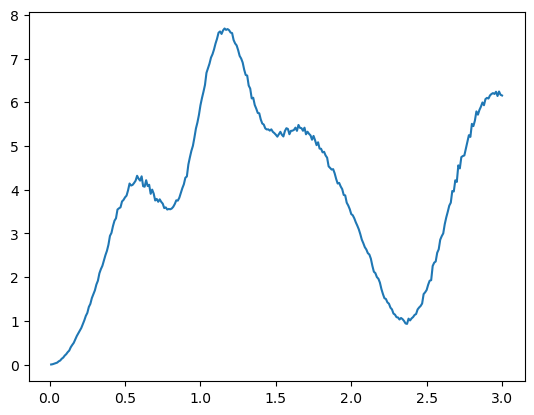

In [8]:
# Plot t - MSD
plt.plot(t, msd_list)
plt.show()

In [10]:
# Save qd_list
import pickle

with open(f'data/simulator/{backend}_{name}_qd_list.pkl','wb') as file :
    pickle.dump(qd_list, file)

In [11]:
# Save msd_list
import csv

with open(f'data/simulator/{backend}_{name}_msd_list.csv','w') as file :
    write = csv.writer(file)
    write.writerow(msd_list)